# Ensemble Canônico
---
Ilum Escola de Ciência

- Disciplina: Fundamentos da Termodinâmica Avançada
- Professor: Felipe Lima
- Alunos: João Caramês, Gustavo Beneti e Ygor Ruas
- Data: 02 de outubro de 2023

---
Veremos diferentes configurações possíveis de células de um material formado por 2 átomos e, com isso, queremos saber que tipo de ordenação é mais favorável, ou seja, é energicamente mais possível de acontecer. Para isso, seguiremos os seguintes passos:

- Escolheremos o tamanho da célula e a proporção entre os átomos.
- Faremos a combinação das posições, encontrando todas as ordenações possíveis.
- Aplicaremos os valores de energia associados às interações entre os átomos e as on-site.
- Encontraremos a Energia Total, a Função de Partição (Z) e a Energia Livre de Helmholtz.
- Análise dos resultados.

---

De início, vamos considerar para análises a Energia Livre na forma (1) e para implementação na forma (2):

1. $$F = U - T \cdot S$$

2. $$F = \beta \cdot ln(Z)$$

## Bibliotecas e Funções

In [1]:
import math
import numpy as np
from itertools import permutations
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def dividir_em_matriz(lista, n):
    """ Essa função divide uma lista em uma matriz quadrada de ordem n
    
    Args:
    
    lista: lista com todos os elementos da matriz.
    n: ordem da matriz quadrada desejada.
    
    Return:
    
    matriz: a matriz quadrada
    """
    
    matriz = [lista[i:i+n] for i in range(0, len(lista), n)]
    return matriz

In [3]:
def celulas(N_A, N_B, n):
    """ Essa função fornece todas as configurações de células possíveis dada a distribuição
    quantitativa dos elementos.
    
    Args:
    
    N_A: número de átomos do elemento A.
    N_B: número de átomos do elemento B.
    n: ordem da matriz.
    
    Return:
    
    matrizes: todas as configurações de células possíveis.
    """
    
    elementos = ["A"] * N_A + ["B"] * N_B
    permutações = set(permutations(elementos))
    matrizes = []
    for permutação in permutações:
        matriz = dividir_em_matriz(list(permutação), n)
        matrizes.append(matriz)
        
    return matrizes

In [4]:
def calcular_vizinhos(matriz):
    """ Essa função fornece um dicionário que relaciona todos os elementos na célula
    a seus vizinhos, tanto os de dentro da célula quanto os de células vizinhas iguais.
    
    Args:
    
        matriz: a célula da qual queremos saber os elementos e seus vizinhos
        
    Return:
    
        vizinhos: um dicionário com as chaves sendo as coordenadas da matriz e os valores os vizinhos dessa coordenada"""
    vizinhos = {}
    linhas = len(matriz)
    colunas = len(matriz[0])

    for i in range(linhas):
        for j in range(colunas):
            vizinhos[(i, j)] = []

            # Vizinhos à direita e abaixo
            if j < colunas - 1:
                vizinhos[(i, j)].append(matriz[i][j + 1])
            if i < linhas - 1:
                vizinhos[(i, j)].append(matriz[i + 1][j])

            # Vizinhos nas bordas
            if j == 0:
                vizinhos[(i, j)].append(matriz[i][colunas - 1])
            if j == colunas - 1:
                vizinhos[(i, j)].append(matriz[i][0])
            if i == 0:
                vizinhos[(i, j)].append(matriz[linhas - 1][j])
            if i == linhas - 1:
                vizinhos[(i, j)].append(matriz[0][j])

    return vizinhos

In [5]:
def vizinhos_energiatotal(matriz, E_AB, E_AA, E_BB):
    """ Essa função calcula a energia de cada vizinho e a energia total da célula.
    
    Args:
        
        matriz: configuração da célula.
        E_AB: energias entre os elementos A e B.
        E_AA: energias entre os elementos A e A.
        E_BB: energias entre os elementos B e B.
        
    Return:
    
        energia_célula: energia total da configuração da célula.
        energias_vizinhos: lista com os valores de energia entre cada vizinho.
    """
    vizinhos_dict = calcular_vizinhos(matriz)
    coordenadas = list(vizinhos_dict.keys())
    energias_vizinhos = []
    
    for coordenada in coordenadas:
        i = coordenada[0]
        j = coordenada[1]
        elemento = matriz[i][j]
        vizinhos = vizinhos_dict[(i,j)]
        
        for vizinho in vizinhos:
            if elemento != vizinho:
                energias_vizinhos.append(E_AB)
            
            if elemento == vizinho:
                if elemento == "A":
                    energias_vizinhos.append(E_AA)
                if elemento == "B":
                    energias_vizinhos.append(E_BB)
    
    energia_célula = sum(energias_vizinhos) + E_on_site

    return energia_célula, energias_vizinhos

In [6]:
def funcao_particao(energias, temperatura):
    """Essa função calcula o valor da função de partição
    
    Args:
        
        energias: lista com a energia de cada configuração da célula.
        temperatura: temperatura na qual estaria a célula.
        
    Return:
    
        Z: valor da função de partição em uma temperatura.
    """
    beta = 1.0 / (Kb * temperatura)
    Z = 0.0
    for energia in energias:
        Z += np.exp(-beta * energia)
    
    return Z

In [7]:
def helmholtz(energias, temperatura):
    """Essa função calcula a energia livre de helmholtz
    
    Args:
    
        energias: lista com a energia de cada configuração da célula.
        temperatura: temperatura na qual a energia está sendo analisada
    
    Return:
        
        F: energia livre de helmholtz
    """
    Z = funcao_particao(energias, temperatura)
    beta = 1.0 / (Kb * temperatura)
    F = beta * np.log(Z)
    return F

In [8]:
def Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas):
    """Essa função realiza toda a análise de caso
    
    Args:
        N_A: número de átomos A.
        N_B: número de átomos B.
        n: ordem da célula quadrada.
        E_AB: energia entre A e B.
        E_AA: energia entre A e A.
        E_BB: energia entre B e B.
        temperatura: intervalo de temperatura em que analisaremos a célula.
        
    Return:
    
        data: dataframe com as informações de temperatura e energia livre de helmholtz.
    """
    energias = []
    lista_helm = []
    células = celulas(N_A, N_B, n)
    
    for cell in células:
        energia_célula, energias_vizinhos = vizinhos_energiatotal(cell, E_AB, E_AA, E_BB)
        energias.append(energia_célula)
    
    for T in temperaturas:
        F = helmholtz(energias, T)
        lista_helm.append(F)
    
    data = pd.DataFrame({"Temperatura": temperaturas, "F": lista_helm})
    return data

## Parâmetros fixos

| Parâmetros | Definição | Valor      |
|------------|-----------|------------|
| n          | Ordem da matriz quadrada que representa a célula | 3 |
| N          | Número de elementos na célula | 9 |
| N_A        | Número de elementos que são A | [0,9] |
| N_B        | Número de elementos que são B | [9,0] |
| E_on_site  | Energia on-site total da célula  (eV)| N_A . E_A + N_B . E_B |
| Kb         | Constante de Boltzmann ($\frac{eV}{K}$) | 8.6173324 . 10^{-5} |
| temperaturas | Intervalor de temperatura (Kelvin) | [250, 550] |

In [9]:
# Parâmetros

## Número de elementos
n = 3
N = int(n**2)

## Constante de Boltzmann
Kb = 8.6173324 * 10**(-5)

## Intervalo de Temperatura
temperaturas = np.arange(250.0, 550.1, 0.1)

## a)

Por determinação do professor Felipe, os seguintes parâmetros serão fixados ao longo dessa análise:

| Parâmetros | Definição | Valor      |
|------------|-----------|------------|
| E_A        | Energia on-site de A (eV)| -1 |
| E_B        | Energia on-site de B (eV)| -1 |
| E_AA       | Energia entre os elementos A e A (eV)| -0.05 |
| E_BB       | Energia entre os elementos B e B (eV)| -0.05 |
| E_AB       | Energia entre os elementos A e B (eV)| -0.05 |

In [10]:
E_A = -1
E_B = -1
E_AA = -0.05
E_BB = -0.05
E_AB = -0.05

In [11]:
# Definição dos casos

N_A = 0
N_B = 9
E_on_site = N_A * E_A + N_B * E_B
meu_caso0 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 1
N_B = 8
E_on_site = N_A * E_A + N_B * E_B
meu_caso1 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 2
N_B = 7
E_on_site = N_A * E_A + N_B * E_B
meu_caso2 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 3
N_B = 6
E_on_site = N_A * E_A + N_B * E_B
meu_caso3 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 4
N_B = 5
E_on_site = N_A * E_A + N_B * E_B
meu_caso4 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 5
N_B = 4
E_on_site = N_A * E_A + N_B * E_B
meu_caso5 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 6
N_B = 3
E_on_site = N_A * E_A + N_B * E_B
meu_caso6 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 7
N_B = 2
E_on_site = N_A * E_A + N_B * E_B
meu_caso7 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 8
N_B = 1
E_on_site = N_A * E_A + N_B * E_B
meu_caso8 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 9
N_B = 0
E_on_site = N_A * E_A + N_B * E_B
meu_caso9 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

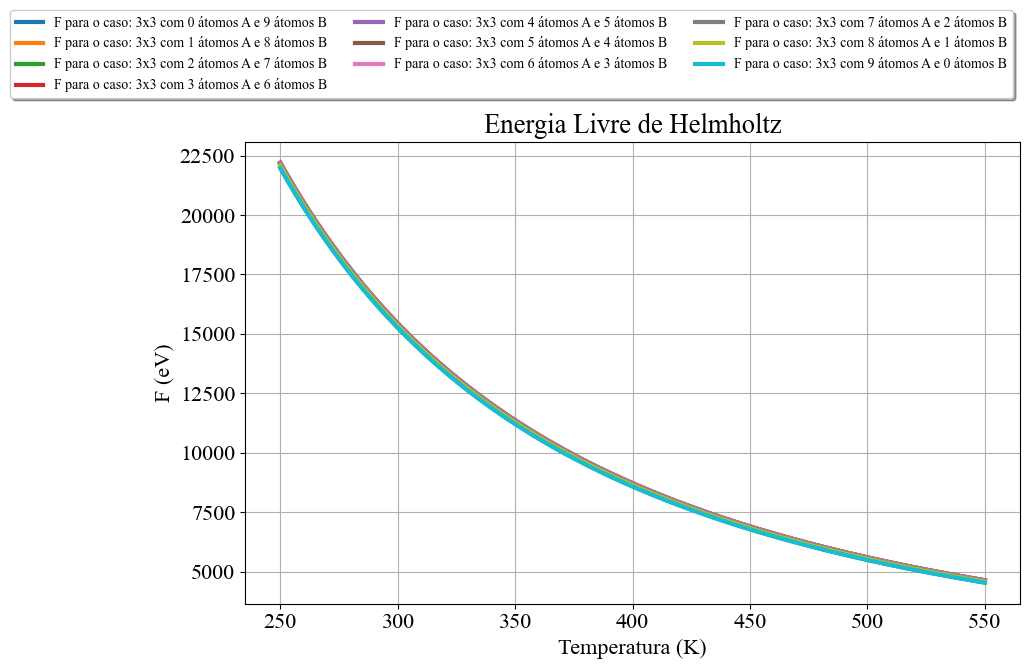

In [12]:
# Crie uma figura
plt.figure(figsize=(10, 6))  # Tamanho da figura

plt.rcParams.update({
    'font.family': "Times New Roman",
    'font.size': 16,  # Tamanho da fonte
    'legend.fontsize': 10,  # Tamanho da fonte na legenda
    'xtick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo x
    'ytick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo y
})

# Plote cada conjunto de dados com uma cor diferente e rótulos grandes

plt.plot(meu_caso0["Temperatura"], meu_caso0["F"], label=f"F para o caso: {n}x{n} com {0} átomos A e {9} átomos B", linewidth=3)
plt.plot(meu_caso1["Temperatura"], meu_caso1["F"], label=f"F para o caso: {n}x{n} com {1} átomos A e {8} átomos B", linewidth=3)
plt.plot(meu_caso2["Temperatura"], meu_caso2["F"], label=f"F para o caso: {n}x{n} com {2} átomos A e {7} átomos B", linewidth=3)
plt.plot(meu_caso3["Temperatura"], meu_caso3["F"], label=f"F para o caso: {n}x{n} com {3} átomos A e {6} átomos B", linewidth=3)
plt.plot(meu_caso4["Temperatura"], meu_caso4["F"], label=f"F para o caso: {n}x{n} com {4} átomos A e {5} átomos B", linewidth=3)
plt.plot(meu_caso5["Temperatura"], meu_caso5["F"], label=f"F para o caso: {n}x{n} com {5} átomos A e {4} átomos B", linewidth=3)
plt.plot(meu_caso6["Temperatura"], meu_caso6["F"], label=f"F para o caso: {n}x{n} com {6} átomos A e {3} átomos B", linewidth=3)
plt.plot(meu_caso7["Temperatura"], meu_caso7["F"], label=f"F para o caso: {n}x{n} com {7} átomos A e {2} átomos B", linewidth=3)
plt.plot(meu_caso8["Temperatura"], meu_caso8["F"], label=f"F para o caso: {n}x{n} com {8} átomos A e {1} átomos B", linewidth=3)
plt.plot(meu_caso9["Temperatura"], meu_caso9["F"], label=f"F para o caso: {n}x{n} com {9} átomos A e {0} átomos B", linewidth=3)

# Adicione um título e rótulos de eixos
plt.title('Energia Livre de Helmholtz')
plt.xlabel('Temperatura (K)')
plt.ylabel('F (eV)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fancybox=True, shadow=True)
plt.grid()

# Exiba o gráfico
plt.show()

In [13]:
print(f'Somatório dos valores de F para o caso A(0) e B(9): {sum(meu_caso0["F"])}')
print(f'Somatório dos valores de F para o caso A(1) e B(8): {sum(meu_caso1["F"])}')
print(f'Somatório dos valores de F para o caso A(2) e B(7): {sum(meu_caso2["F"])}')
print(f'Somatório dos valores de F para o caso A(3) e B(6): {sum(meu_caso3["F"])}')
print(f'Somatório dos valores de F para o caso A(4) e B(5): {sum(meu_caso4["F"])}')
print(f'Somatório dos valores de F para o caso A(5) e B(4): {sum(meu_caso5["F"])}')
print(f'Somatório dos valores de F para o caso A(6) e B(3): {sum(meu_caso6["F"])}')
print(f'Somatório dos valores de F para o caso A(7) e B(2): {sum(meu_caso7["F"])}')
print(f'Somatório dos valores de F para o caso A(8) e B(1): {sum(meu_caso8["F"])}')
print(f'Somatório dos valores de F para o caso A(9) e B(0): {sum(meu_caso9["F"])}')

Somatório dos valores de F para o caso A(0) e B(9): 29982314.574893273
Somatório dos valores de F para o caso A(1) e B(8): 30183427.520962477
Somatório dos valores de F para o caso A(2) e B(7): 30310315.662465937
Somatório dos valores de F para o caso A(3) e B(6): 30387869.21373166
Somatório dos valores de F para o caso A(4) e B(5): 30424981.616014514
Somatório dos valores de F para o caso A(5) e B(4): 30424981.616014514
Somatório dos valores de F para o caso A(6) e B(3): 30387869.21373166
Somatório dos valores de F para o caso A(7) e B(2): 30310315.662465937
Somatório dos valores de F para o caso A(8) e B(1): 30183427.520962477
Somatório dos valores de F para o caso A(9) e B(0): 29982314.574893273


### Comentário

Os comentários estão na cor da configuração de menor energia correspondente no gráfico.

<font color='cyan'><font size='4'>Podemos verificar por meio do gráfico e dos valores somados que as configurações de menor energia são as puras, ou seja, com elementos únicos, seja A ou B. Isso acontece pois os valores de energia definidos as tornam indiferentes para a configuração da célula e a preferência por uma célula pura se dar pelo menor número de configurações possíveis para a célula, o que resulta em uma menor entropia do sistema e, como podemos ver na equação, a energia livre de Helmholtz depende da energia interna, da temperatura e da entropia, sendo que o único parâmetros diferentes nesses casos é a entropia.

## b)

Por determinação do professor Felipe, os seguintes parâmetros serão fixados ao longo dessa análise:

| Parâmetros | Definição | Valor      |
|------------|-----------|------------|
| E_A        | Energia on-site de A (eV)| -1 |
| E_B        | Energia on-site de B (eV)| -1 |
| E_AA       | Energia entre os elementos A e A (eV)| -0.05 |
| E_BB       | Energia entre os elementos B e B (eV)| -0.02 |
| E_AB       | Energia entre os elementos A e B (eV)| -0.06 |

In [14]:
E_A = -1
E_B = -1
E_AA = -0.05
E_BB = -0.02
E_AB = -0.06

In [15]:
# Definição dos casos

N_A = 0
N_B = 9
E_on_site = N_A * E_A + N_B * E_B
meu_caso0 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 1
N_B = 8
E_on_site = N_A * E_A + N_B * E_B
meu_caso1 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 2
N_B = 7
E_on_site = N_A * E_A + N_B * E_B
meu_caso2 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 3
N_B = 6
E_on_site = N_A * E_A + N_B * E_B
meu_caso3 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 4
N_B = 5
E_on_site = N_A * E_A + N_B * E_B
meu_caso4 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 5
N_B = 4
E_on_site = N_A * E_A + N_B * E_B
meu_caso5 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 6
N_B = 3
E_on_site = N_A * E_A + N_B * E_B
meu_caso6 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 7
N_B = 2
E_on_site = N_A * E_A + N_B * E_B
meu_caso7 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 8
N_B = 1
E_on_site = N_A * E_A + N_B * E_B
meu_caso8 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 9
N_B = 0
E_on_site = N_A * E_A + N_B * E_B
meu_caso9 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

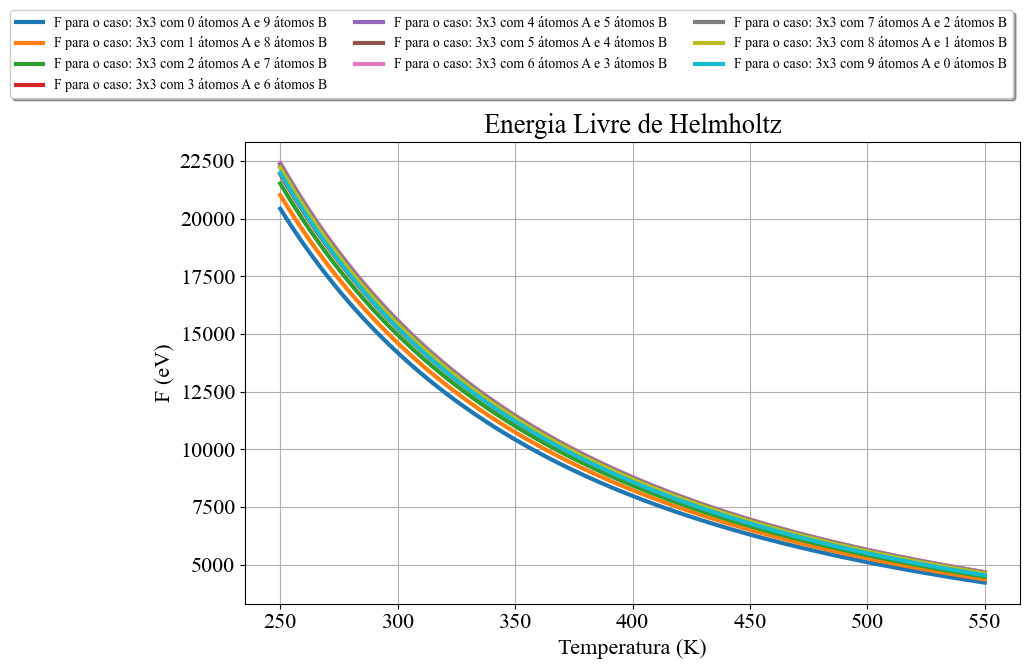

In [16]:
# Crie uma figura
plt.figure(figsize=(10, 6))  # Tamanho da figura

plt.rcParams.update({
    'font.family': "Times New Roman",
    'font.size': 16,  # Tamanho da fonte
    'legend.fontsize': 10,  # Tamanho da fonte na legenda
    'xtick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo x
    'ytick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo y
})

# Plote cada conjunto de dados com uma cor diferente e rótulos grandes

plt.plot(meu_caso0["Temperatura"], meu_caso0["F"], label=f"F para o caso: {n}x{n} com {0} átomos A e {9} átomos B", linewidth=3)
plt.plot(meu_caso1["Temperatura"], meu_caso1["F"], label=f"F para o caso: {n}x{n} com {1} átomos A e {8} átomos B", linewidth=3)
plt.plot(meu_caso2["Temperatura"], meu_caso2["F"], label=f"F para o caso: {n}x{n} com {2} átomos A e {7} átomos B", linewidth=3)
plt.plot(meu_caso3["Temperatura"], meu_caso3["F"], label=f"F para o caso: {n}x{n} com {3} átomos A e {6} átomos B", linewidth=3)
plt.plot(meu_caso4["Temperatura"], meu_caso4["F"], label=f"F para o caso: {n}x{n} com {4} átomos A e {5} átomos B", linewidth=3)
plt.plot(meu_caso5["Temperatura"], meu_caso5["F"], label=f"F para o caso: {n}x{n} com {5} átomos A e {4} átomos B", linewidth=3)
plt.plot(meu_caso6["Temperatura"], meu_caso6["F"], label=f"F para o caso: {n}x{n} com {6} átomos A e {3} átomos B", linewidth=3)
plt.plot(meu_caso7["Temperatura"], meu_caso7["F"], label=f"F para o caso: {n}x{n} com {7} átomos A e {2} átomos B", linewidth=3)
plt.plot(meu_caso8["Temperatura"], meu_caso8["F"], label=f"F para o caso: {n}x{n} com {8} átomos A e {1} átomos B", linewidth=3)
plt.plot(meu_caso9["Temperatura"], meu_caso9["F"], label=f"F para o caso: {n}x{n} com {9} átomos A e {0} átomos B", linewidth=3)

# Adicione um título e rótulos de eixos
plt.title('Energia Livre de Helmholtz')
plt.xlabel('Temperatura (K)')
plt.ylabel('F (eV)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fancybox=True, shadow=True)
plt.grid()

# Exiba o gráfico
plt.show()

In [17]:
print(f'Somatório dos valores de F para o caso A(0) e B(9): {sum(meu_caso0["F"])}')
print(f'Somatório dos valores de F para o caso A(1) e B(8): {sum(meu_caso1["F"])}')
print(f'Somatório dos valores de F para o caso A(2) e B(7): {sum(meu_caso2["F"])}')
print(f'Somatório dos valores de F para o caso A(3) e B(6): {sum(meu_caso3["F"])}')
print(f'Somatório dos valores de F para o caso A(4) e B(5): {sum(meu_caso4["F"])}')
print(f'Somatório dos valores de F para o caso A(5) e B(4): {sum(meu_caso5["F"])}')
print(f'Somatório dos valores de F para o caso A(6) e B(3): {sum(meu_caso6["F"])}')
print(f'Somatório dos valores de F para o caso A(7) e B(2): {sum(meu_caso7["F"])}')
print(f'Somatório dos valores de F para o caso A(8) e B(1): {sum(meu_caso8["F"])}')
print(f'Somatório dos valores de F para o caso A(9) e B(0): {sum(meu_caso9["F"])}')

Somatório dos valores de F para o caso A(0) e B(9): 27865915.899018373
Somatório dos valores de F para o caso A(1) e B(8): 28722811.812622134
Somatório dos valores de F para o caso A(2) e B(7): 29434860.42336425
Somatório dos valores de F para o caso A(3) e B(6): 29999428.440096114
Somatório dos valores de F para o caso A(4) e B(5): 30402509.398334928
Somatório dos valores de F para o caso A(5) e B(4): 30617280.4422417
Somatório dos valores de F para o caso A(6) e B(3): 30684133.62744274
Somatório dos valores de F para o caso A(7) e B(2): 30575535.96766621
Somatório dos valores de F para o caso A(8) e B(1): 30342309.628233865
Somatório dos valores de F para o caso A(9) e B(0): 29982314.574893273


<font color='blue'><font size='4'>Dessa vez, a configuração de menor energia ainda é uma das puras, porém, apenas a com elementos B. Agora, isso aconteceu pois os valores de energia entre os vizinhos se diferem, resultando numa configuração com preferência por mais elementos B, pois a energia entre eles é maior que entre B e A e A e A, além de que a entropia desse caso é menor também.

## c)

Por determinação do professor Felipe, os seguintes parâmetros serão fixados ao longo dessa análise:

| Parâmetros | Definição | Valor      |
|------------|-----------|------------|
| E_A        | Energia on-site de A (eV)| -1 |
| E_B        | Energia on-site de B (eV)| -1 |
| E_AA       | Energia entre os elementos A e A (eV)| -0.05 |
| E_BB       | Energia entre os elementos B e B (eV)| -0.02 |
| E_AB       | Energia entre os elementos A e B (eV)| 0.06 |

In [18]:
E_A = -1
E_B = -1
E_AA = -0.05
E_BB = -0.02
E_AB = 0.06

In [19]:
# Definição dos casos

N_A = 0
N_B = 9
E_on_site = N_A * E_A + N_B * E_B
meu_caso0 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 1
N_B = 8
E_on_site = N_A * E_A + N_B * E_B
meu_caso1 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 2
N_B = 7
E_on_site = N_A * E_A + N_B * E_B
meu_caso2 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 3
N_B = 6
E_on_site = N_A * E_A + N_B * E_B
meu_caso3 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 4
N_B = 5
E_on_site = N_A * E_A + N_B * E_B
meu_caso4 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 5
N_B = 4
E_on_site = N_A * E_A + N_B * E_B
meu_caso5 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 6
N_B = 3
E_on_site = N_A * E_A + N_B * E_B
meu_caso6 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 7
N_B = 2
E_on_site = N_A * E_A + N_B * E_B
meu_caso7 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 8
N_B = 1
E_on_site = N_A * E_A + N_B * E_B
meu_caso8 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 9
N_B = 0
E_on_site = N_A * E_A + N_B * E_B
meu_caso9 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

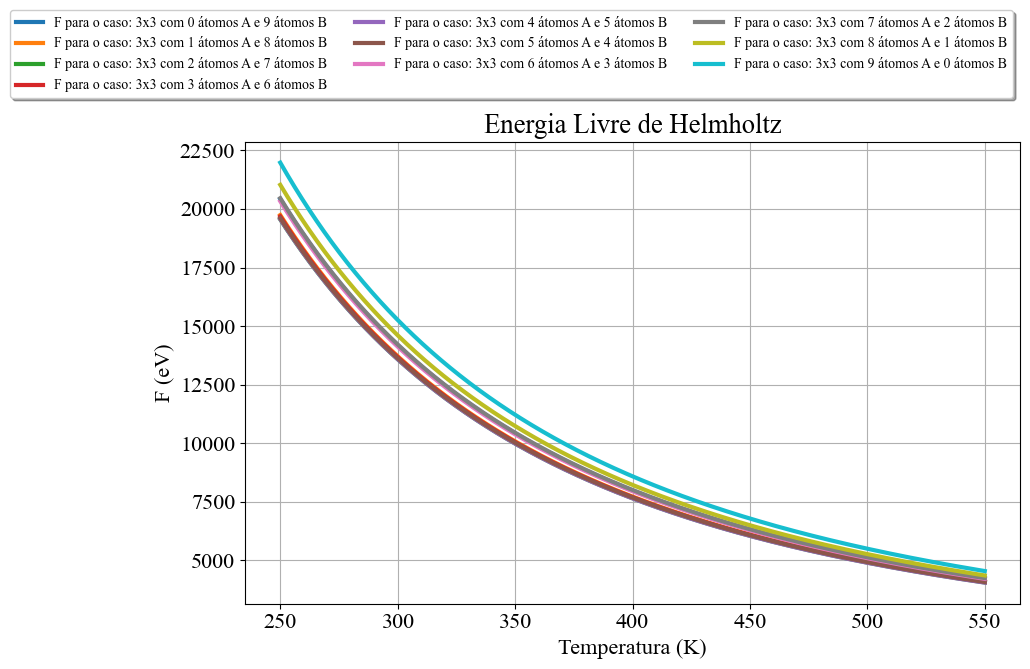

In [20]:
# Crie uma figura
plt.figure(figsize=(10, 6))  # Tamanho da figura

plt.rcParams.update({
    'font.family': "Times New Roman",
    'font.size': 16,  # Tamanho da fonte
    'legend.fontsize': 10,  # Tamanho da fonte na legenda
    'xtick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo x
    'ytick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo y
})

# Plote cada conjunto de dados com uma cor diferente e rótulos grandes

plt.plot(meu_caso0["Temperatura"], meu_caso0["F"], label=f"F para o caso: {n}x{n} com {0} átomos A e {9} átomos B", linewidth=3)
plt.plot(meu_caso1["Temperatura"], meu_caso1["F"], label=f"F para o caso: {n}x{n} com {1} átomos A e {8} átomos B", linewidth=3)
plt.plot(meu_caso2["Temperatura"], meu_caso2["F"], label=f"F para o caso: {n}x{n} com {2} átomos A e {7} átomos B", linewidth=3)
plt.plot(meu_caso3["Temperatura"], meu_caso3["F"], label=f"F para o caso: {n}x{n} com {3} átomos A e {6} átomos B", linewidth=3)
plt.plot(meu_caso4["Temperatura"], meu_caso4["F"], label=f"F para o caso: {n}x{n} com {4} átomos A e {5} átomos B", linewidth=3)
plt.plot(meu_caso5["Temperatura"], meu_caso5["F"], label=f"F para o caso: {n}x{n} com {5} átomos A e {4} átomos B", linewidth=3)
plt.plot(meu_caso6["Temperatura"], meu_caso6["F"], label=f"F para o caso: {n}x{n} com {6} átomos A e {3} átomos B", linewidth=3)
plt.plot(meu_caso7["Temperatura"], meu_caso7["F"], label=f"F para o caso: {n}x{n} com {7} átomos A e {2} átomos B", linewidth=3)
plt.plot(meu_caso8["Temperatura"], meu_caso8["F"], label=f"F para o caso: {n}x{n} com {8} átomos A e {1} átomos B", linewidth=3)
plt.plot(meu_caso9["Temperatura"], meu_caso9["F"], label=f"F para o caso: {n}x{n} com {9} átomos A e {0} átomos B", linewidth=3)

# Adicione um título e rótulos de eixos
plt.title('Energia Livre de Helmholtz')
plt.xlabel('Temperatura (K)')
plt.ylabel('F (eV)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fancybox=True, shadow=True)
plt.grid()

# Exiba o gráfico
plt.show()

In [21]:
print(f'Somatório dos valores de F para o caso A(0) e B(9): {sum(meu_caso0["F"])}')
print(f'Somatório dos valores de F para o caso A(1) e B(8): {sum(meu_caso1["F"])}')
print(f'Somatório dos valores de F para o caso A(2) e B(7): {sum(meu_caso2["F"])}')
print(f'Somatório dos valores de F para o caso A(3) e B(6): {sum(meu_caso3["F"])}')
print(f'Somatório dos valores de F para o caso A(4) e B(5): {sum(meu_caso4["F"])}')
print(f'Somatório dos valores de F para o caso A(5) e B(4): {sum(meu_caso5["F"])}')
print(f'Somatório dos valores de F para o caso A(6) e B(3): {sum(meu_caso6["F"])}')
print(f'Somatório dos valores de F para o caso A(7) e B(2): {sum(meu_caso7["F"])}')
print(f'Somatório dos valores de F para o caso A(8) e B(1): {sum(meu_caso8["F"])}')
print(f'Somatório dos valores de F para o caso A(9) e B(0): {sum(meu_caso9["F"])}')

Somatório dos valores de F para o caso A(0) e B(9): 27865915.899018373
Somatório dos valores de F para o caso A(1) e B(8): 26954879.53067358
Somatório dos valores de F para o caso A(2) e B(7): 26703377.110433348
Somatório dos valores de F para o caso A(3) e B(6): 26871494.836544283
Somatório dos valores de F para o caso A(4) e B(5): 26695399.759684503
Somatório dos valores de F para o caso A(5) e B(4): 26801097.19004526
Somatório dos valores de F para o caso A(6) e B(3): 27753043.33980251
Somatório dos valores de F para o caso A(7) e B(2): 27944570.514430568
Somatório dos valores de F para o caso A(8) e B(1): 28702418.9923402
Somatório dos valores de F para o caso A(9) e B(0): 29982314.574893273


<font color='purple'><font size='4'>Dessa maneira, a configuração de menor energia é a com 4 elementos A e 5 elementos B e isso ocorre devido aos valores de energia maiores para A e B vizinhos e com preferência à B e B por ter maior energia do que A e A, resultando em A(4) com B(5) ao invés de A(5) com B(4).

## d)

Por determinação do professor Felipe, os seguintes parâmetros serão fixados ao longo dessa análise:

| Parâmetros | Definição | Valor      |
|------------|-----------|------------|
| E_A        | Energia on-site de A (eV)| -1 |
| E_B        | Energia on-site de B (eV)| -0.6 |
| E_AA       | Energia entre os elementos A e A (eV)| -0.1 |
| E_BB       | Energia entre os elementos B e B (eV)| -0.2 |
| E_AB       | Energia entre os elementos A e B (eV)| -0.3 |

In [22]:
E_A = -1
E_B = -0.6
E_AA = -0.1
E_BB = -0.2
E_AB = -0.3

In [23]:
# Definição dos casos

N_A = 0
N_B = 9
E_on_site = N_A * E_A + N_B * E_B
meu_caso0 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 1
N_B = 8
E_on_site = N_A * E_A + N_B * E_B
meu_caso1 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 2
N_B = 7
E_on_site = N_A * E_A + N_B * E_B
meu_caso2 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 3
N_B = 6
E_on_site = N_A * E_A + N_B * E_B
meu_caso3 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 4
N_B = 5
E_on_site = N_A * E_A + N_B * E_B
meu_caso4 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 5
N_B = 4
E_on_site = N_A * E_A + N_B * E_B
meu_caso5 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 6
N_B = 3
E_on_site = N_A * E_A + N_B * E_B
meu_caso6 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 7
N_B = 2
E_on_site = N_A * E_A + N_B * E_B
meu_caso7 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 8
N_B = 1
E_on_site = N_A * E_A + N_B * E_B
meu_caso8 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 9
N_B = 0
E_on_site = N_A * E_A + N_B * E_B
meu_caso9 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

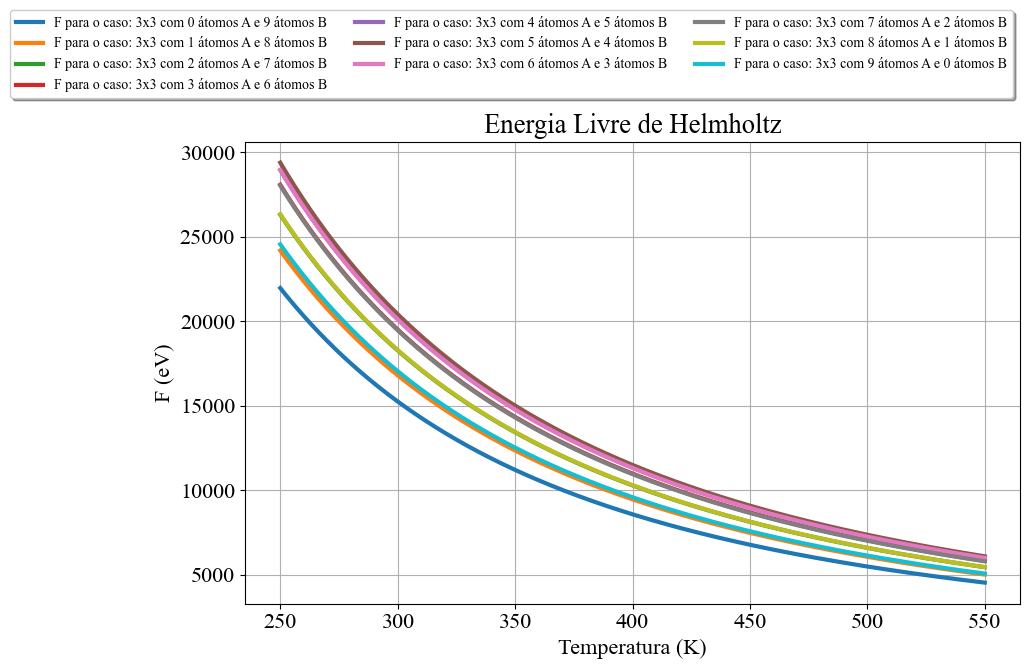

In [24]:
# Crie uma figura
plt.figure(figsize=(10, 6))  # Tamanho da figura

plt.rcParams.update({
    'font.family': "Times New Roman",
    'font.size': 16,  # Tamanho da fonte
    'legend.fontsize': 10,  # Tamanho da fonte na legenda
    'xtick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo x
    'ytick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo y
})

# Plote cada conjunto de dados com uma cor diferente e rótulos grandes

plt.plot(meu_caso0["Temperatura"], meu_caso0["F"], label=f"F para o caso: {n}x{n} com {0} átomos A e {9} átomos B", linewidth=3)
plt.plot(meu_caso1["Temperatura"], meu_caso1["F"], label=f"F para o caso: {n}x{n} com {1} átomos A e {8} átomos B", linewidth=3)
plt.plot(meu_caso2["Temperatura"], meu_caso2["F"], label=f"F para o caso: {n}x{n} com {2} átomos A e {7} átomos B", linewidth=3)
plt.plot(meu_caso3["Temperatura"], meu_caso3["F"], label=f"F para o caso: {n}x{n} com {3} átomos A e {6} átomos B", linewidth=3)
plt.plot(meu_caso4["Temperatura"], meu_caso4["F"], label=f"F para o caso: {n}x{n} com {4} átomos A e {5} átomos B", linewidth=3)
plt.plot(meu_caso5["Temperatura"], meu_caso5["F"], label=f"F para o caso: {n}x{n} com {5} átomos A e {4} átomos B", linewidth=3)
plt.plot(meu_caso6["Temperatura"], meu_caso6["F"], label=f"F para o caso: {n}x{n} com {6} átomos A e {3} átomos B", linewidth=3)
plt.plot(meu_caso7["Temperatura"], meu_caso7["F"], label=f"F para o caso: {n}x{n} com {7} átomos A e {2} átomos B", linewidth=3)
plt.plot(meu_caso8["Temperatura"], meu_caso8["F"], label=f"F para o caso: {n}x{n} com {8} átomos A e {1} átomos B", linewidth=3)
plt.plot(meu_caso9["Temperatura"], meu_caso9["F"], label=f"F para o caso: {n}x{n} com {9} átomos A e {0} átomos B", linewidth=3)

# Adicione um título e rótulos de eixos
plt.title('Energia Livre de Helmholtz')
plt.xlabel('Temperatura (K)')
plt.ylabel('F (eV)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fancybox=True, shadow=True)
plt.grid()

# Exiba o gráfico
plt.show()

In [25]:
print(f'Somatório dos valores de F para o caso A(0) e B(9): {sum(meu_caso0["F"])}')
print(f'Somatório dos valores de F para o caso A(1) e B(8): {sum(meu_caso1["F"])}')
print(f'Somatório dos valores de F para o caso A(2) e B(7): {sum(meu_caso2["F"])}')
print(f'Somatório dos valores de F para o caso A(3) e B(6): {sum(meu_caso3["F"])}')
print(f'Somatório dos valores de F para o caso A(4) e B(5): {sum(meu_caso4["F"])}')
print(f'Somatório dos valores de F para o caso A(5) e B(4): {sum(meu_caso5["F"])}')
print(f'Somatório dos valores de F para o caso A(6) e B(3): {sum(meu_caso6["F"])}')
print(f'Somatório dos valores de F para o caso A(7) e B(2): {sum(meu_caso7["F"])}')
print(f'Somatório dos valores de F para o caso A(8) e B(1): {sum(meu_caso8["F"])}')
print(f'Somatório dos valores de F para o caso A(9) e B(0): {sum(meu_caso9["F"])}')

Somatório dos valores de F para o caso A(0) e B(9): 29982314.574893273
Somatório dos valores de F para o caso A(1) e B(8): 33053240.555610664
Somatório dos valores de F para o caso A(2) e B(7): 35942150.98219546
Somatório dos valores de F para o caso A(3) e B(6): 38377240.85732182
Somatório dos valores de F para o caso A(4) e B(5): 39583565.488614835
Somatório dos valores de F para o caso A(5) e B(4): 40167115.9559213
Somatório dos valores de F para o caso A(6) e B(3): 39558525.61645112
Somatório dos valores de F para o caso A(7) e B(2): 38277530.39932222
Somatório dos valores de F para o caso A(8) e B(1): 35988422.754682265
Somatório dos valores de F para o caso A(9) e B(0): 33509645.70135128


<font color='blue'><font size='4'>À vista disso, vemos que a preferência é da configuração A(0) e B(9) pois a energia on-site dos elementos B é maior que dos elementos A. Além disso, a grande diferença desses valores de energia prevaleceu sobre as energias entre vizinhos, resultando em curvas bem diferentes, como podemos ver no gráfico.

## e)

Por determinação do professor Felipe, os seguintes parâmetros serão fixados ao longo dessa análise:

| Parâmetros | Definição | Valor      |
|------------|-----------|------------|
| E_A        | Energia on-site de A (eV)| -0.05 |
| E_B        | Energia on-site de B (eV)| -0.06 |
| E_AA       | Energia entre os elementos A e A (eV)| -0.1 |
| E_BB       | Energia entre os elementos B e B (eV)| -0.2 |
| E_AB       | Energia entre os elementos A e B (eV)| -0.3 |

In [26]:
E_A = 0
E_B = 0
E_AA = -0.1
E_BB = -0.2
E_AB = -0.3

In [27]:
# Definição dos casos

N_A = 0
N_B = 9
E_on_site = N_A * E_A + N_B * E_B
meu_caso0 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 1
N_B = 8
E_on_site = N_A * E_A + N_B * E_B
meu_caso1 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 2
N_B = 7
E_on_site = N_A * E_A + N_B * E_B
meu_caso2 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 3
N_B = 6
E_on_site = N_A * E_A + N_B * E_B
meu_caso3 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 4
N_B = 5
E_on_site = N_A * E_A + N_B * E_B
meu_caso4 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 5
N_B = 4
E_on_site = N_A * E_A + N_B * E_B
meu_caso5 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 6
N_B = 3
E_on_site = N_A * E_A + N_B * E_B
meu_caso6 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 7
N_B = 2
E_on_site = N_A * E_A + N_B * E_B
meu_caso7 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 8
N_B = 1
E_on_site = N_A * E_A + N_B * E_B
meu_caso8 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 9
N_B = 0
E_on_site = N_A * E_A + N_B * E_B
meu_caso9 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

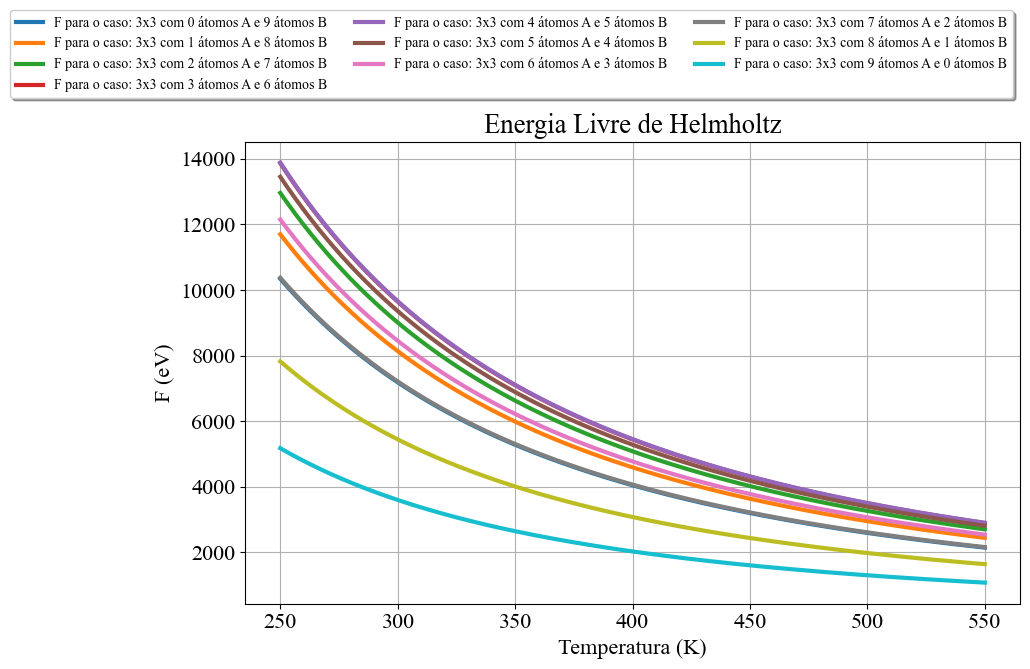

In [28]:
# Crie uma figura
plt.figure(figsize=(10, 6))  # Tamanho da figura

plt.rcParams.update({
    'font.family': "Times New Roman",
    'font.size': 16,  # Tamanho da fonte
    'legend.fontsize': 10,  # Tamanho da fonte na legenda
    'xtick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo x
    'ytick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo y
})

# Plote cada conjunto de dados com uma cor diferente e rótulos grandes

plt.plot(meu_caso0["Temperatura"], meu_caso0["F"], label=f"F para o caso: {n}x{n} com {0} átomos A e {9} átomos B", linewidth=3)
plt.plot(meu_caso1["Temperatura"], meu_caso1["F"], label=f"F para o caso: {n}x{n} com {1} átomos A e {8} átomos B", linewidth=3)
plt.plot(meu_caso2["Temperatura"], meu_caso2["F"], label=f"F para o caso: {n}x{n} com {2} átomos A e {7} átomos B", linewidth=3)
plt.plot(meu_caso3["Temperatura"], meu_caso3["F"], label=f"F para o caso: {n}x{n} com {3} átomos A e {6} átomos B", linewidth=3)
plt.plot(meu_caso4["Temperatura"], meu_caso4["F"], label=f"F para o caso: {n}x{n} com {4} átomos A e {5} átomos B", linewidth=3)
plt.plot(meu_caso5["Temperatura"], meu_caso5["F"], label=f"F para o caso: {n}x{n} com {5} átomos A e {4} átomos B", linewidth=3)
plt.plot(meu_caso6["Temperatura"], meu_caso6["F"], label=f"F para o caso: {n}x{n} com {6} átomos A e {3} átomos B", linewidth=3)
plt.plot(meu_caso7["Temperatura"], meu_caso7["F"], label=f"F para o caso: {n}x{n} com {7} átomos A e {2} átomos B", linewidth=3)
plt.plot(meu_caso8["Temperatura"], meu_caso8["F"], label=f"F para o caso: {n}x{n} com {8} átomos A e {1} átomos B", linewidth=3)
plt.plot(meu_caso9["Temperatura"], meu_caso9["F"], label=f"F para o caso: {n}x{n} com {9} átomos A e {0} átomos B", linewidth=3)

# Adicione um título e rótulos de eixos
plt.title('Energia Livre de Helmholtz')
plt.xlabel('Temperatura (K)')
plt.ylabel('F (eV)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fancybox=True, shadow=True)
plt.grid()

# Exiba o gráfico
plt.show()

In [29]:
print(f'Somatório dos valores de F para o caso A(0) e B(9): {sum(meu_caso0["F"])}')
print(f'Somatório dos valores de F para o caso A(1) e B(8): {sum(meu_caso1["F"])}')
print(f'Somatório dos valores de F para o caso A(2) e B(7): {sum(meu_caso2["F"])}')
print(f'Somatório dos valores de F para o caso A(3) e B(6): {sum(meu_caso3["F"])}')
print(f'Somatório dos valores de F para o caso A(4) e B(5): {sum(meu_caso4["F"])}')
print(f'Somatório dos valores de F para o caso A(5) e B(4): {sum(meu_caso5["F"])}')
print(f'Somatório dos valores de F para o caso A(6) e B(3): {sum(meu_caso6["F"])}')
print(f'Somatório dos valores de F para o caso A(7) e B(2): {sum(meu_caso7["F"])}')
print(f'Somatório dos valores de F para o caso A(8) e B(1): {sum(meu_caso8["F"])}')
print(f'Somatório dos valores de F para o caso A(9) e B(0): {sum(meu_caso9["F"])}')

Somatório dos valores de F para o caso A(0) e B(9): 14109324.505832085
Somatório dos valores de F para o caso A(1) e B(8): 16004473.444396809
Somatório dos valores de F para o caso A(2) e B(7): 17717606.82882898
Somatório dos valores de F para o caso A(3) e B(6): 18976919.66180265
Somatório dos valores de F para o caso A(4) e B(5): 19007467.250942964
Somatório dos valores de F para o caso A(5) e B(4): 18415240.67609683
Somatório dos valores de F para o caso A(6) e B(3): 16630873.294474112
Somatório dos valores de F para o caso A(7) e B(2): 14174101.035192335
Somatório dos valores de F para o caso A(8) e B(1): 10709216.34839977
Somatório dos valores de F para o caso A(9) e B(0): 7054662.252916043


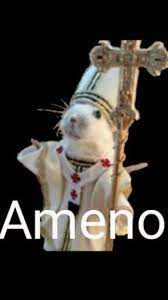

<font color='cyan'><font size='4'>Nessa oportunidade, temos A menor (acima, apenas um meme). A razão é que os valores de energia on-site de A e, especialmente, vizinhos A e A, são menores, dando uma prevalência muito maior para os elementos A.

## f)

Por determinação do professor Felipe, os seguintes parâmetros serão fixados ao longo dessa análise:

| Parâmetros | Definição | Valor      |
|------------|-----------|------------|
| E_A        | Energia on-site de A (eV)| -0.05 |
| E_B        | Energia on-site de B (eV)| -0.06 |
| E_AA       | Energia entre os elementos A e A (eV)| -0.01 |
| E_BB       | Energia entre os elementos B e B (eV)| -0.02 |
| E_AB       | Energia entre os elementos A e B (eV)| -0.03 |

In [30]:
E_A = -0.05
E_B = -0.06
E_AA = -0.01
E_BB = -0.02
E_AB = -0.03

In [31]:
# Definição dos casos

N_A = 0
N_B = 9
E_on_site = N_A * E_A + N_B * E_B
meu_caso0 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 1
N_B = 8
E_on_site = N_A * E_A + N_B * E_B
meu_caso1 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 2
N_B = 7
E_on_site = N_A * E_A + N_B * E_B
meu_caso2 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 3
N_B = 6
E_on_site = N_A * E_A + N_B * E_B
meu_caso3 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 4
N_B = 5
E_on_site = N_A * E_A + N_B * E_B
meu_caso4 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 5
N_B = 4
E_on_site = N_A * E_A + N_B * E_B
meu_caso5 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 6
N_B = 3
E_on_site = N_A * E_A + N_B * E_B
meu_caso6 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 7
N_B = 2
E_on_site = N_A * E_A + N_B * E_B
meu_caso7 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 8
N_B = 1
E_on_site = N_A * E_A + N_B * E_B
meu_caso8 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

N_A = 9
N_B = 0
E_on_site = N_A * E_A + N_B * E_B
meu_caso9 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)

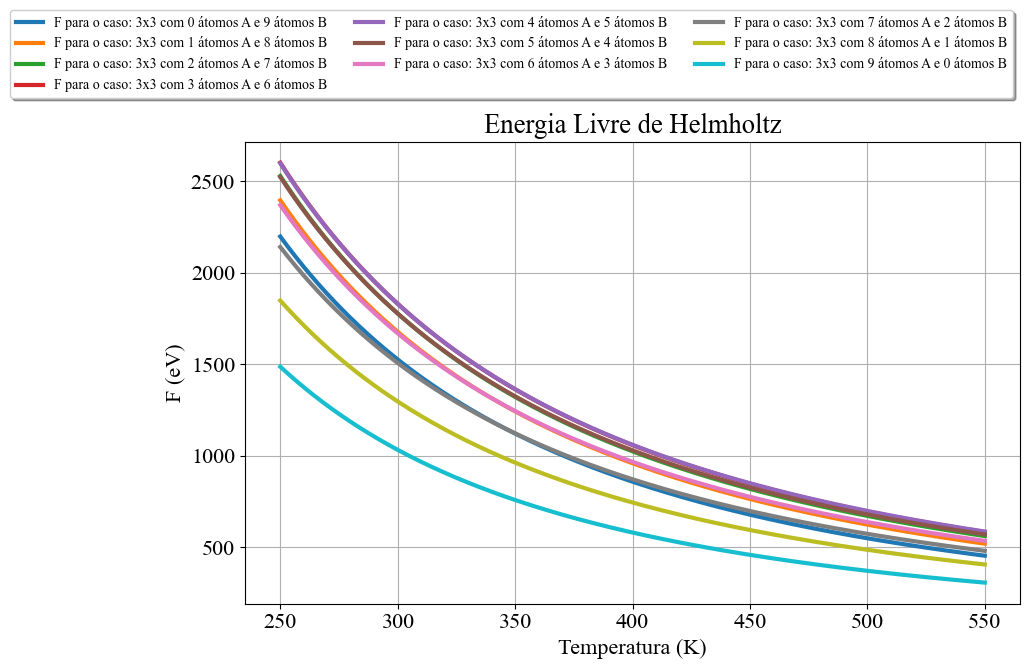

In [32]:
# Crie uma figura
plt.figure(figsize=(10, 6))  # Tamanho da figura

plt.rcParams.update({
    'font.family': "Times New Roman",
    'font.size': 16,  # Tamanho da fonte
    'legend.fontsize': 10,  # Tamanho da fonte na legenda
    'xtick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo x
    'ytick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo y
})

# Plote cada conjunto de dados com uma cor diferente e rótulos grandes

plt.plot(meu_caso0["Temperatura"], meu_caso0["F"], label=f"F para o caso: {n}x{n} com {0} átomos A e {9} átomos B", linewidth=3)
plt.plot(meu_caso1["Temperatura"], meu_caso1["F"], label=f"F para o caso: {n}x{n} com {1} átomos A e {8} átomos B", linewidth=3)
plt.plot(meu_caso2["Temperatura"], meu_caso2["F"], label=f"F para o caso: {n}x{n} com {2} átomos A e {7} átomos B", linewidth=3)
plt.plot(meu_caso3["Temperatura"], meu_caso3["F"], label=f"F para o caso: {n}x{n} com {3} átomos A e {6} átomos B", linewidth=3)
plt.plot(meu_caso4["Temperatura"], meu_caso4["F"], label=f"F para o caso: {n}x{n} com {4} átomos A e {5} átomos B", linewidth=3)
plt.plot(meu_caso5["Temperatura"], meu_caso5["F"], label=f"F para o caso: {n}x{n} com {5} átomos A e {4} átomos B", linewidth=3)
plt.plot(meu_caso6["Temperatura"], meu_caso6["F"], label=f"F para o caso: {n}x{n} com {6} átomos A e {3} átomos B", linewidth=3)
plt.plot(meu_caso7["Temperatura"], meu_caso7["F"], label=f"F para o caso: {n}x{n} com {7} átomos A e {2} átomos B", linewidth=3)
plt.plot(meu_caso8["Temperatura"], meu_caso8["F"], label=f"F para o caso: {n}x{n} com {8} átomos A e {1} átomos B", linewidth=3)
plt.plot(meu_caso9["Temperatura"], meu_caso9["F"], label=f"F para o caso: {n}x{n} com {9} átomos A e {0} átomos B", linewidth=3)

# Adicione um título e rótulos de eixos
plt.title('Energia Livre de Helmholtz')
plt.xlabel('Temperatura (K)')
plt.ylabel('F (eV)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fancybox=True, shadow=True)
plt.grid()

# Exiba o gráfico
plt.show()

In [33]:
print(f'Somatório dos valores de F para o caso A(0) e B(9): {sum(meu_caso0["F"])}')
print(f'Somatório dos valores de F para o caso A(1) e B(8): {sum(meu_caso1["F"])}')
print(f'Somatório dos valores de F para o caso A(2) e B(7): {sum(meu_caso2["F"])}')
print(f'Somatório dos valores de F para o caso A(3) e B(6): {sum(meu_caso3["F"])}')
print(f'Somatório dos valores de F para o caso A(4) e B(5): {sum(meu_caso4["F"])}')
print(f'Somatório dos valores de F para o caso A(5) e B(4): {sum(meu_caso5["F"])}')
print(f'Somatório dos valores de F para o caso A(6) e B(3): {sum(meu_caso6["F"])}')
print(f'Somatório dos valores de F para o caso A(7) e B(2): {sum(meu_caso7["F"])}')
print(f'Somatório dos valores de F para o caso A(8) e B(1): {sum(meu_caso8["F"])}')
print(f'Somatório dos valores de F para o caso A(9) e B(0): {sum(meu_caso9["F"])}')

Somatório dos valores de F para o caso A(0) e B(9): 2998231.4574893266
Somatório dos valores de F para o caso A(1) e B(8): 3328832.084776172
Somatório dos valores de F para o caso A(2) e B(7): 3544022.9652164895
Somatório dos valores de F para o caso A(3) e B(6): 3658033.921248445
Somatório dos valores de F para o caso A(4) e B(5): 3661393.8748847684
Somatório dos valores de F para o caso A(5) e B(4): 3557037.8240705756
Somatório dos valores de F para o caso A(6) e B(3): 3340071.7680858774
Somatório dos valores de F para o caso A(7) e B(2): 3012289.206875608
Somatório dos valores de F para o caso A(8) e B(1): 2580297.337462811
Somatório dos valores de F para o caso A(9) e B(0): 2028215.3977133622


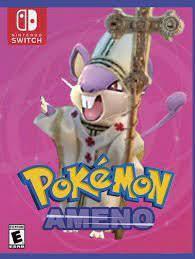

<font color='cyan'><font size='4'>Esse último caso se difere mais nos valores finais da energia livre  quantitativamente do que qualitativamente em relação ao caso anterior. Assim, seguimos com A menor (mais um meme) por ter os valores on-site e entre vizinhos menor.

## 2)

A adição de mais um átomo - o átomo C -  resulta na alteração da função "celulas", uma vez que altera as configurações possíveis do sistema, ou seja, existem mais permutações possíveis relativas à organização do sistema. <p>
A função "vizinhos_energiatotal" deveria ser alterada, uma vez que como poderiam haver configurações com vizinhos "C", deveria-se adicionar: energias entre os elementos entre A e c; B e C; C e C, o que altera as energias possíveis dos sitema. <p>
Por consequência, os valores de helmholtz se alterariam, dado que tem como input as energias do sistema para o cálculo da função partição (que também se alteraria pela presença de C)